In [2]:
!pip install pygame

     |████████████████████████████████| 18.3 MB 20 kB/s 


In [3]:
import pygame
import matplotlib.pyplot as plt

pygame 2.1.0 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
class Snake:
    def __init__(self, size):
        self.clock = pygame.time.Clock()
        self.s = size
        self.orientation = 0    # Facing: 0-up 1-right 2-down 3-left.
        self.actions = np.array([[-1, 0], [0, 1], [1, 0], [0, -1]])   # ↑, →, ↓, ←.
        self.last_turn = 0

    def act(self, action):      # Action: 0-left 1-forward 2-right.
        self.orientation = (self.orientation + action - 1) % 4      # Update orientation based on action.
        new_pos = self.snake[0] + self.actions[self.orientation]    # Update position based on orientation.

        if action != 1:
            self.last_turn = action / 2

        no_wall_collision = (0 <= new_pos[0] < self.s) and (0 <= new_pos[1] < self.s)
        no_tail_collision = all(np.any(pos != new_pos) for pos in self.snake[:-1])
        
        if no_wall_collision and no_tail_collision and self.time < self.s ** 2:
            self.snake = np.insert(self.snake, 0, new_pos, axis=0)

            if np.all(new_pos == self.apple):
                if len(self.snake) < self.s ** 2:
                    self.reset_apple()
                    l = len(self.snake)
                    return self.state(), l, len(self.snake) ** 2, False     # Reward for eating an apple.
                return self.state(), len(self.snake), 1000000, True         # High reward for completing the game.

            self.time += 1
            self.snake = np.delete(self.snake, -1, axis=0)
            return self.state(), len(self.snake), -self.time, False         # Negative reward that accumulates per move.

        return self.state(), len(self.snake), -1000, True                   # Massive Negative reward for dying.

    def state(self):    # Returns an unique numerical representation of the state (from what snake can see).
        x, y = self.snake[0, 0], self.snake[0, 1]
        ori = self.orientation

        # Vision #1: presence of a wall/tail in the immediate surroundings (left forward right).
        surrounding = np.empty(3)
        for i in range(3):
            new_ori = (ori + i - 1) % 4
            new_pos = np.array([x, y]) + self.actions[new_ori]
            no_wall_collision = (0 <= new_pos[0] < self.s) and (0 <= new_pos[1] < self.s)
            no_tail_collision = all(np.any(pos != new_pos) for pos in self.snake[:-1])
            surrounding[i] = not (no_wall_collision and no_tail_collision)
        vis1 = surrounding[0] * 4 + surrounding[1] * 2 + surrounding[2]

        # Vision #2: presence of a tail in 3 directions (left forward right).
        tail = np.zeros(4)
        for i, pos in enumerate(self.snake):
            end_idx = len(self.snake) - i
            if pos[0] == x:
                if pos[1] > y and pos[1] - y < end_idx: 
                    tail[(2 - ori) % 4] = 1
                elif pos[1] < y and y - pos[1] < end_idx: 
                    tail[(0 - ori) % 4] = 1
            elif pos[1] == y:
                if pos[0] > x and pos[0] - x < end_idx: 
                    tail[(3 - ori) % 4] = 1
                elif pos[0] < x and x - pos[0] < end_idx: 
                    tail[(1 - ori) % 4] = 1
        vis2 = tail[0] * 4 + tail[1] * 2 + tail[2]

        # Vision #3: relative apple location in 8 quadrants (↑ ↖︎ ← ↙︎ ↓ ↘︎ → ↗︎).
        ax, ay = self.apple[0], self.apple[1]
        if ax < x and ay == y: vis3 = (0 + 2 * ori) % 8
        elif ax < x and ay < y: vis3 = (1 + 2 * ori) % 8
        elif ax == x and ay < y: vis3 = (2 + 2 * ori) % 8
        elif ax > x and ay < y: vis3 = (3 + 2 * ori) % 8
        elif ax > x and ay == y: vis3 = (4 + 2 * ori) % 8
        elif ax > x and ay > y: vis3 = (5 + 2 * ori) % 8
        elif ax == x and ay > y: vis3 = (6 + 2 * ori) % 8
        elif ax < x and ay > y: vis3 = (7 + 2 * ori) % 8
        else: return 0

        # Vision #4: last turn (left right).
        vis4 = self.last_turn

        # Vision #5: length of the snake (short long).
        vis5 = len(self.snake) < self.s ** 2 / 3

        return int(vis1 * 256 + vis2 * 32 + vis3 * 4 + vis4 * 2 + vis5 + 1)

    def restart(self):
        self.frame_iteration = 0
        self.snake = np.array([np.random.randint(self.s, size = 2)])
        self.reset_apple()
        return self.state()

    def reset_apple(self):
        grid = np.stack(np.meshgrid(range(self.s), range(self.s)), -1).reshape(-1, 2)
        pos = np.array(list({tuple(r) for r in grid} - {tuple(r) for r in self.snake}))
        self.apple = pos[np.random.randint(len(pos))]
        self.time = 0

        
    def play_step(self, action):
        self.frame_iteration += 1
        pygame.init()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
        
        # 2. move
        next_state, length, reward, done = self.act(action)
        
        if reward==-1000:
            pygame.quit()
#             quit()
            return next_state, length, reward, done
        
        # 3. update ui and clock
        self._update_ui()
        self.clock.tick(10)
        
        return next_state, length, reward, done

    def _update_ui(self):
        BLOCK = 50
        game_screen = pygame.display.set_mode((self.s*BLOCK, self.s*BLOCK))
        pygame.display.set_caption('Snake game Q-learning')
        clock = pygame.time.Clock()
        game_screen.fill((0,0,0))
        
        for pt in self.snake:
            pygame.draw.rect(game_screen , (255,255,255), [pt[0]*BLOCK,pt[1]*BLOCK,BLOCK, BLOCK])
            
        pygame.draw.rect(game_screen , (255,0,0), [self.apple[0]*BLOCK,self.apple[1]*BLOCK,BLOCK, BLOCK])
        pygame.display.flip()


In [5]:
def train(grid_size, epoch_size, batch_size, alpha_base, gamma_base, epsilon_base):
    snake = Snake(grid_size)
    bestavg=[0,alpha_base[0],gamma_base[0],epsilon_base[0]]
    parameter = []
    for Ialpha in alpha_base:
        for Iepsilon in epsilon_base:
            for gamma in gamma_base:
                
                alpha = Ialpha
                epsilon = Iepsilon
                
                q_table = np.zeros((2049, 3))   # 8 * 8 * 8 * 2 * 2 + 1 states, 3 actions.
                avglen = []
                maxlen = []

                for epoch in range(epoch_size):
                    alpha -= Ialpha / epoch_size        # Decaying learning rate (α).
                    epsilon -= 1.25 * Iepsilon / epoch_size    # Decaying random movement rate (ε).

                    lens = []

                    for _ in range(batch_size):
                        state = snake.restart()
                        done = False
                        while not done:
                            action = np.argmax(q_table[state]) if epsilon < np.random.uniform() else np.random.randint(3)
                            next_state, length, reward, done = snake.act(action)
                            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (reward + gamma * q_table[next_state].max())
                            state = next_state
                        lens.append(length)

                    print(f'#{epoch} Average length: {round(np.mean(lens), 3)}. Max length: {max(lens)}. α={round(alpha, 3)} ε={round(epsilon, 3)}')
                    if(bestavg[0]<round(np.mean(lens), 3)):
                        bestavg[0]=round(np.mean(lens), 3)
                        bestavg[1]=Ialpha
                        bestavg[2]=gamma
                        bestavg[3]=Iepsilon
                    avglen.append(round(np.mean(lens), 3))
                    maxlen.append(max(lens))
                hyperparameters = str(Ialpha)+" "+str(gamma)+" "+str(Iepsilon)
                parameter.append([round(np.mean(avglen), 3),hyperparameters])
                plt.clf()
                x = [*range(0,epoch_size,1)]
                plt.plot(x, avglen, label='Average Length')
                plt.plot(x, maxlen, label='Max Length')
                plt.xlabel("Epoch number")
                plt.ylabel("Score")
                plt.title("Score vs Epoch number a={}, g={}, e={}".format(Ialpha,gamma, Iepsilon))
                plt.legend()
#                 plt.show()
                plt.savefig('snakePerf_{}_{}_{}.png'.format(Ialpha,gamma, Iepsilon))
    print(bestavg)
    print(parameter)
    plt.clf()
#     x = [*range(0,epoch_size,1)]
    for y in parameter:
        plt.bar(y[1], y[0],width=0.2)
    plt.xlabel("Epoch number")
    plt.ylabel("Score")
    plt.xticks(rotation=90)
    plt.title("Score vs Epoch number")
    plt.savefig('Hyperparameters.png')
    
    return q_table

In [6]:
def test(grid_size, q_table):
    snake = Snake(grid_size)

    lens = []
    state = snake.restart()
    done = False
    while not done:
        action = np.argmax(q_table[state])
        next_state, length, reward, done = snake.play_step(action)
        state = next_state

    print(f'Max length attained: {length}')
    
    return length

In [8]:
import numpy as np
grid_size = 10
epoch_size = 100
batch_size = 100

alpha, gamma, epsilon = [0.2, 0.5, 0.8], [0.2, 0.5, 0.8], [0.2,0.9]   # Hyper parameters

q_table = train(grid_size, epoch_size, batch_size, alpha, gamma, epsilon)

#0 Average length: 1.67. Max length: 7. α=0.198 ε=0.198
#1 Average length: 2.43. Max length: 7. α=0.196 ε=0.195
#2 Average length: 2.02. Max length: 7. α=0.194 ε=0.193
#3 Average length: 1.93. Max length: 8. α=0.192 ε=0.19
#4 Average length: 1.57. Max length: 7. α=0.19 ε=0.188
#5 Average length: 2.0. Max length: 8. α=0.188 ε=0.185
#6 Average length: 2.35. Max length: 9. α=0.186 ε=0.182
#7 Average length: 3.76. Max length: 11. α=0.184 ε=0.18
#8 Average length: 2.95. Max length: 12. α=0.182 ε=0.177
#9 Average length: 2.39. Max length: 11. α=0.18 ε=0.175
#10 Average length: 2.66. Max length: 8. α=0.178 ε=0.172
#11 Average length: 2.39. Max length: 12. α=0.176 ε=0.17
#12 Average length: 3.11. Max length: 13. α=0.174 ε=0.167
#13 Average length: 3.8. Max length: 15. α=0.172 ε=0.165
#14 Average length: 4.22. Max length: 13. α=0.17 ε=0.162
#15 Average length: 3.12. Max length: 12. α=0.168 ε=0.16
#16 Average length: 2.7. Max length: 15. α=0.166 ε=0.157
#17 Average length: 2.88. Max length: 8. α

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
grid_size = 5
epoch_size = 10
batch_size = 10

alpha, gamma, epsilon = [0.2], [0.8], [0.2]

q_table = train(grid_size, epoch_size, batch_size, alpha, gamma, epsilon)

#0 Average length: 1.2. Max length: 2. α=0.18 ε=0.175
#1 Average length: 1.2. Max length: 2. α=0.16 ε=0.15
#2 Average length: 1.6. Max length: 4. α=0.14 ε=0.125
#3 Average length: 3.4. Max length: 7. α=0.12 ε=0.1
#4 Average length: 3.7. Max length: 7. α=0.1 ε=0.075
#5 Average length: 5.0. Max length: 9. α=0.08 ε=0.05
#6 Average length: 4.0. Max length: 7. α=0.06 ε=0.025
#7 Average length: 6.4. Max length: 9. α=0.04 ε=0.0
#8 Average length: 7.8. Max length: 10. α=0.02 ε=-0.025
#9 Average length: 7.2. Max length: 9. α=0.0 ε=-0.05


Max length attained: 1
Max length attained: 7
Max length attained: 9
Max length attained: 1
Max length attained: 9
Max length attained: 9
Max length attained: 1
Max length attained: 7
Max length attained: 9
Max length attained: 7


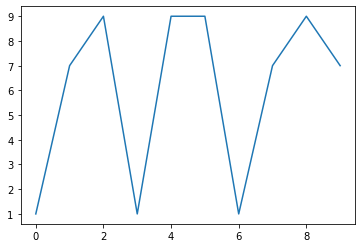

In [ ]:
lens=[]
iteration = [*range(10)]
for i in iteration:
    lens.append(test(5, q_table))
plt.plot(iteration, lens)
plt.show()

#0 Average length: 1.78. Max length: 8. α=0.2 ε=0.399
#1 Average length: 2.28. Max length: 8. α=0.199 ε=0.398
#2 Average length: 2.52. Max length: 8. α=0.199 ε=0.397
#3 Average length: 2.945. Max length: 9. α=0.198 ε=0.396
#4 Average length: 2.68. Max length: 9. α=0.198 ε=0.395
#5 Average length: 2.725. Max length: 9. α=0.198 ε=0.394
#6 Average length: 2.905. Max length: 9. α=0.197 ε=0.393
#7 Average length: 2.695. Max length: 9. α=0.197 ε=0.392
#8 Average length: 2.89. Max length: 9. α=0.196 ε=0.391
#9 Average length: 2.675. Max length: 10. α=0.196 ε=0.39
#10 Average length: 2.75. Max length: 9. α=0.196 ε=0.389
#11 Average length: 3.155. Max length: 9. α=0.195 ε=0.388
#12 Average length: 3.085. Max length: 10. α=0.195 ε=0.387
#13 Average length: 2.975. Max length: 9. α=0.194 ε=0.386
#14 Average length: 2.61. Max length: 9. α=0.194 ε=0.385
#15 Average length: 2.985. Max length: 9. α=0.194 ε=0.384
#16 Average length: 2.94. Max length: 9. α=0.193 ε=0.383
#17 Average length: 2.785. Max le

#142 Average length: 3.355. Max length: 18. α=0.143 ε=0.257
#143 Average length: 3.98. Max length: 14. α=0.142 ε=0.256
#144 Average length: 3.63. Max length: 15. α=0.142 ε=0.255
#145 Average length: 2.98. Max length: 13. α=0.142 ε=0.254
#146 Average length: 2.125. Max length: 8. α=0.141 ε=0.253
#147 Average length: 1.84. Max length: 7. α=0.141 ε=0.252
#148 Average length: 2.36. Max length: 9. α=0.14 ε=0.251
#149 Average length: 2.295. Max length: 8. α=0.14 ε=0.25
#150 Average length: 1.635. Max length: 6. α=0.14 ε=0.249
#151 Average length: 1.63. Max length: 6. α=0.139 ε=0.248
#152 Average length: 1.905. Max length: 9. α=0.139 ε=0.247
#153 Average length: 2.32. Max length: 8. α=0.138 ε=0.246
#154 Average length: 2.895. Max length: 11. α=0.138 ε=0.245
#155 Average length: 3.05. Max length: 10. α=0.138 ε=0.244
#156 Average length: 3.63. Max length: 15. α=0.137 ε=0.243
#157 Average length: 3.46. Max length: 16. α=0.137 ε=0.242
#158 Average length: 4.03. Max length: 14. α=0.136 ε=0.241
#15

#281 Average length: 4.79. Max length: 20. α=0.087 ε=0.118
#282 Average length: 4.2. Max length: 19. α=0.087 ε=0.117
#283 Average length: 4.385. Max length: 20. α=0.086 ε=0.116
#284 Average length: 5.25. Max length: 17. α=0.086 ε=0.115
#285 Average length: 5.95. Max length: 20. α=0.086 ε=0.114
#286 Average length: 3.73. Max length: 18. α=0.085 ε=0.113
#287 Average length: 5.225. Max length: 16. α=0.085 ε=0.112
#288 Average length: 5.66. Max length: 19. α=0.084 ε=0.111
#289 Average length: 6.1. Max length: 19. α=0.084 ε=0.11
#290 Average length: 5.355. Max length: 18. α=0.084 ε=0.109
#291 Average length: 6.205. Max length: 23. α=0.083 ε=0.108
#292 Average length: 6.11. Max length: 17. α=0.083 ε=0.107
#293 Average length: 5.635. Max length: 18. α=0.082 ε=0.106
#294 Average length: 5.775. Max length: 18. α=0.082 ε=0.105
#295 Average length: 5.815. Max length: 17. α=0.082 ε=0.104
#296 Average length: 6.255. Max length: 19. α=0.081 ε=0.103
#297 Average length: 6.275. Max length: 17. α=0.081

#418 Average length: 15.115. Max length: 25. α=0.032 ε=-0.019
#419 Average length: 15.375. Max length: 25. α=0.032 ε=-0.02
#420 Average length: 15.125. Max length: 25. α=0.032 ε=-0.021
#421 Average length: 15.625. Max length: 25. α=0.031 ε=-0.022
#422 Average length: 15.62. Max length: 25. α=0.031 ε=-0.023
#423 Average length: 15.16. Max length: 25. α=0.03 ε=-0.024
#424 Average length: 15.255. Max length: 25. α=0.03 ε=-0.025
#425 Average length: 14.945. Max length: 25. α=0.03 ε=-0.026
#426 Average length: 15.085. Max length: 25. α=0.029 ε=-0.027
#427 Average length: 15.405. Max length: 25. α=0.029 ε=-0.028
#428 Average length: 14.855. Max length: 25. α=0.028 ε=-0.029
#429 Average length: 14.95. Max length: 25. α=0.028 ε=-0.03
#430 Average length: 15.015. Max length: 25. α=0.028 ε=-0.031
#431 Average length: 14.78. Max length: 25. α=0.027 ε=-0.032
#432 Average length: 15.22. Max length: 25. α=0.027 ε=-0.033
#433 Average length: 14.9. Max length: 25. α=0.026 ε=-0.034
#434 Average length:

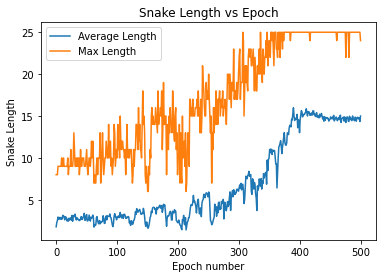

In [ ]:
import numpy as np
grid_size = 5
epoch_size = 500
batch_size = 200

alpha, gamma, epsilon = 0.2, 0.6, 0.4   # Hyper parameters

q_table = train(grid_size, epoch_size, batch_size, alpha, gamma, epsilon)

In [ ]:
test(grid_size, q_table)

Max length attained: 18
